## Selective Classification Can Magnify Disparities Across Groups


### AM207: Advanced Scientific Computing

#### Team: Jamelle Watson-Daniels, Shirley Wang, Bridger Ruyle, Paul Tembo

#### Paper: https://arxiv.org/pdf/2010.14134.pdf: 

### High Level Summary

Selective classification performs predictions only when the model is highly confident in the outcome (for example, $p(y | x) > 0.5 + 𝛕$ for binary classifiers where $𝛕$ is a threshold chosen by the model user). Abstaining from prediction when the model is uncertain has nice properties including improving average and out of distribution accuracies. In this paper, the authors demonstrate that this phenomenon is theoretically guaranteed for models with confidence distributions that are left-log concave and right skewed (i.e. skewed towards correct predictions) and that accurately predict the outcome $>50\%$ of the time. However, for models that do not accurately predict the outcome $>50\%$ of the time, or for subgroups in larger models whose outcomes are poorly predicted, selective classification decreases predictive accuracy. This phenomenon is “an insidious failure mode” because selective classification will increasingly make wrong predictions with greater confidence, particularly for groups with poor accuracy at full coverage, thus magnifying between-group disparities. Even for subgroups that are accurately predicted $>50\%$ of the time, selective classification improves accuracy for these groups at a slower rate compared to the overall model. Therefore selective classification can exacerbate inter-group disparities in model performance and raises concern for equity because disadvantaged or at-risk subgroups which may be most harmed by an incorrect prediction are often underrepresented in the overall dataset and therefore have lower accuracies than the model average. This can be particularly concerning in high-stakes applications (e.g., healthcare, criminal justice systems) where model bias and group disparities are already major issues. 

In the paper, the authors demonstrate this phenomenon on five datasets that are known to develop spurious correlations during training. They also discuss a potential way to mitigate this problem by training the model using group distributionally robust optimization which minimizes the worst-group training loss instead of the overall training loss for the dataset. In this method, the confidence distribution of the worst-group more closely matches the distribution of the overall model and thus selective classification affects both subgroups and the overall data equally. To use this approach you need to know group labels during training, but these labels can be removed during for testing/deployment.


### Project Overview

The paper reports that selective classification can magnify existing group disparities particularly in the presence of spurious correlations demonstrating this behavior across five datasets. In this project, we examine the following question: what are the dataset characteristics the lead to the increased disparities? Because the paper notes the importance of spurious correlations, we bring our attention to varying levels of correlations. We consider the image classification setting and generate synthetic datasets with varying degrees of spurious correlations. Then, we analyze the margin distributions and the selective accuracy of both the overall dataset and the worst group. Ultimately, we compare these results for the varying degrees of spurious correlations to make conclusions about the importance of the dataset characteristics in obtaining the specific magnifying group disparities result.

### Generating Synthetic Data

The paper claims to consider datasets known to have spurious correlations. The image datasets used in the paper contain over 100,000 examples and are not practical for use in this project analysis. Therefore, we generate synthetic datasets derived from the MNIST dataset where we add spurious correlations of varying degrees. 

Specifically, we download the `mnist` dataset and select two numbers for the binary classification task. We introduce spurious attributes as filled in pixels added to the empty space on the upper left hand corner of a given image. These filled pixels can be thought of as boxes that will be correlated with one of the labels. In essence, a given label might then be correlated not only with the original written digit in the `mnist` dataset, but also with whether or not the image contains this added black box. In the training dataset, we add these black boxes to a percentage of the images with each label $Y \in {0,1}$. To mimic the characteristics of the `celebA` dataset used in the paper, we keep the percentage of images with $Y = 0$ label constant at 8.5%. This means that we only add black boxes to 8.5% of training examples with the label $Y = 0$. We generate four datasets with different proportions of examples with the $Y = 1$ label altered: 30%, 50%, 70% and 90%. This results in spurious correlations between the added black box and the $Y = 1$ label.

We consider the task of classifying digits 1 and 7. And we alter the data such that the digit 1 is spuriously correlated with the added black box. Concretely, inputs are `mnist` digits, labels are digit number Y = {1, 7}, and suprious attributes are black boxes, A = {present, absent}, with added black boxes associated with digit 7. Of the four groups, digit 1 with black boxes are the smallest group. 

In [1]:
from autograd import grad
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

import seaborn as sns

/Users/WMP/.pyenv/versions/3.7.8/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version = 1, return_X_y = True, as_frame = False)

In [3]:
# Pick out two classes of digits: 1, 7 and take a subset of samples 
X_subset = X[((y == '1') | (y == '7'))]
y_subset = y[((y == '1') | (y == '7'))]

# Encode the label '1' with y = 1, and the label '7' with y = 0
y_subset[y_subset == '1'] = 1
y_subset[y_subset == '7'] = 0
y_subset = y_subset.astype(int)

In [4]:
# Split into training and testing sets
# Following celebA: 80% training, 10% val, 10% test 

rand_seed = 123
X_train, X_test_tot, y_train, y_test_tot = train_test_split(X_subset, y_subset, test_size = 0.2, random_state = rand_seed) # split out train
X_val, X_test, y_val, y_test = train_test_split(X_test_tot, y_test_tot, test_size = 0.5, random_state = rand_seed) # split out validation set 

In [5]:
# save y_train, y_val, y_test labels in data folder

np.savetxt('data/y_train.csv', y_train, delimiter = ',')
np.savetxt('data/y_val.csv', y_val, delimiter = ',')
np.savetxt('data/y_test.csv', y_test, delimiter = ',')

In [6]:
os.getcwd()

'/Users/WMP/Documents/GitHub/am207-2021'

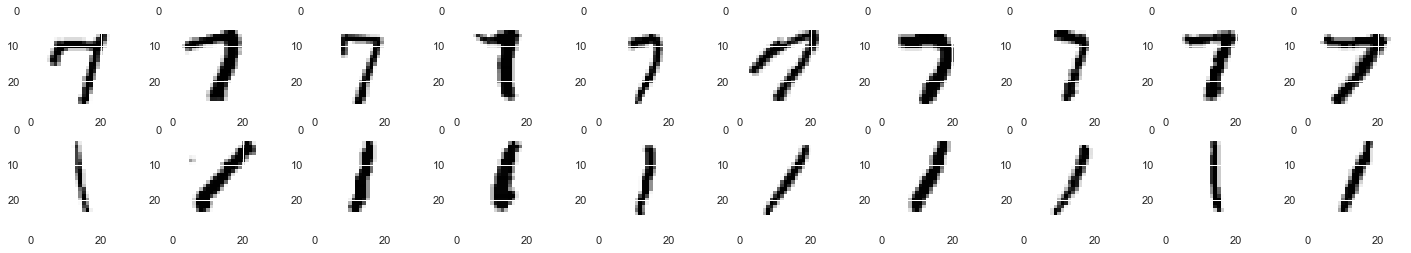

In [7]:
# Visualize some samples from the training dataset 
fig, ax = plt.subplots(2, 10, figsize = (25, 4))
for i in range(10):
    ax[0, i].imshow(X_train[y_train == 0][i].reshape((28, 28)), cmap = plt.cm.gray_r, interpolation = 'nearest')
    ax[1, i].imshow(X_train[y_train == 1][i].reshape((28, 28)), cmap = plt.cm.gray_r, interpolation = 'nearest')

In [8]:
# function to add a grey rectangular box to top left-hand corner of digit

def add_spurious_ft(x_array, y_array, perc_spurious_1, perc_spurious_2):
    '''
    this function takes in x and y arrays, adds spurious features to some images, and returns 
    the altered image array, along with indices of the images that were altered. spurious features
    include a grey box on the upper lefthand side of the image.
    
    x_array: array of shape (n_images, 784)
    y_array: array of shape (n_images, )
    perc_spurious_1: percent of digit 1 images to add spurious features to
    perc_spurious_2: percent of digit 1 images to add spurious features to

    returns: 
        altered image array
        indices of altered images (0 = not altered, 1 = altered)
    '''
    
    indices_1 = np.asarray(np.where(y_train == 1)).reshape(-1) # indices where digit = 1 
    indices_2 = np.asarray(np.where(y_train == 0)).reshape(-1) # indices where digit = 2 
    
    num_digit_1 = len(indices_1) # number of digit 1 images 
    num_digit_2 = len(indices_2) # number of digit 2 images 

    num_alter_1 = int(perc_spurious_1 * num_digit_1) # number of digit 1 images to alter
    num_alter_2 = int(perc_spurious_2 * num_digit_2) # number of digit 2 images to alter
    
    np.random.seed(123)
    rand_indices_1 = np.random.choice(len(indices_1), size = num_alter_1, replace = False) 
    rand_indices_2 = np.random.choice(len(indices_2), size = num_alter_2, replace = False) 
    
    grey_boxes = np.r_[0:15, 28:43, 56:71]
    altered_imgs = x_array
    
    image_altered = []
    
    for i in range(len(altered_imgs)):
        
        # alter digit 2 images 
        if y_train[i] == 0:
            if i in rand_indices_2:
                altered_imgs[i][grey_boxes] = np.array([256] * len(grey_boxes))
                image_altered.append(1) # 1 = altered 
            else:
                image_altered.append(0) # 0 = not altered
        
        # alter digit 1 images 
        elif y_train[i] == 1:
            if i in rand_indices_1:
                altered_imgs[i][grey_boxes] = np.array([256] * len(grey_boxes))
                image_altered.append(1)
            else: 
                image_altered.append(0)
    
    return altered_imgs, np.array(image_altered)

In [9]:
# test to see if the function works 
test_altered_imgs, test_altered_indices = add_spurious_ft(X_train, y_train, 0.085, 0.7)

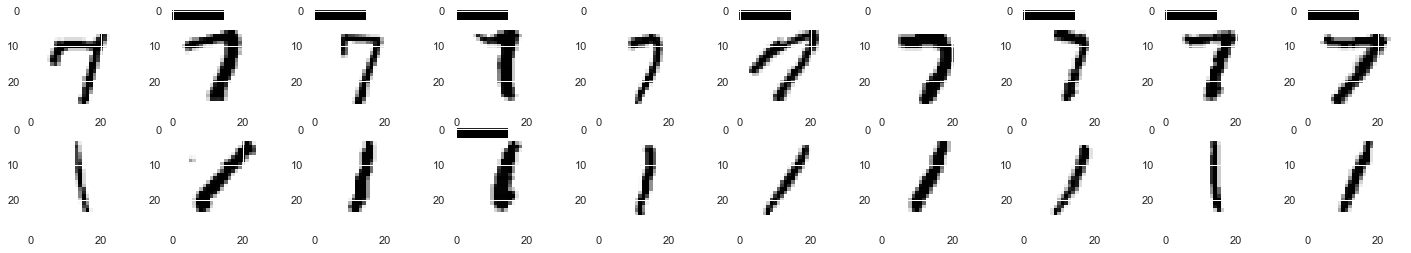

In [10]:
# Visualize some samples from the altered training dataset. more 2's with spurious features than 1's. seems to work! 
fig, ax = plt.subplots(2, 10, figsize = (25, 4))
for i in range(10):
    ax[0, i].imshow(test_altered_imgs[y_train == 0][i].reshape((28, 28)), cmap = plt.cm.gray_r, interpolation = 'nearest')
    ax[1, i].imshow(test_altered_imgs[y_train == 1][i].reshape((28, 28)), cmap = plt.cm.gray_r, interpolation = 'nearest')

#### Generate 4 Sets of Image Datasets (Train, Val, Test): 

`X_train_9`, `X_val_9`, `X_test_9`: 90% spurious features in digit 2; 8.5% spurious features in digit 1.

`X_train_7`, `X_val_7`, `X_test_7`: 70% spurious features in digit 2; 8.5% spurious features in digit 1.

`X_train_5`, `X_val_5`, `X_test_5`: 50% spurious features in digit 2; 8.5% spurious features in digit 1.

`X_train_3`, `X_val_3`, `X_test_3`: 30% spurious features in digit 2; 8.5% spurious features in digit 1.

In [11]:
pct_label_0 = 0.085
# 90% spurious in digit 7 
X_train_9, X_train_9_altindices = add_spurious_ft(X_train, y_train, pct_label_0, 0.9)
X_val_9, X_val_9_altindices = add_spurious_ft(X_val, y_val, pct_label_0, 0.9)
X_test_9, X_test_9_altindices = add_spurious_ft(X_test, y_test, pct_label_0, 0.9)

# 70% spurious in digit 7 
X_train_7, X_train_7_altindices = add_spurious_ft(X_train, y_train, pct_label_0, 0.7)
X_val_7, X_val_7_altindices = add_spurious_ft(X_val, y_val, pct_label_0, 0.7)
X_test_7, X_test_7_altindices = add_spurious_ft(X_test, y_test, pct_label_0, 0.7)

# 50% spurious in digit 7
X_train_5, X_train_5_altindices = add_spurious_ft(X_train, y_train, pct_label_0, 0.5)
X_val_5, X_val_5_altindices = add_spurious_ft(X_val, y_val, pct_label_0, 0.5)
X_test_5, X_test_5_altindices = add_spurious_ft(X_test, y_test, pct_label_0, 0.5)

# 30% spurious in digit7
X_train_3, X_train_3_altindices = add_spurious_ft(X_train, y_train, pct_label_0, 0.3)
X_val_3, X_val_3_altindices = add_spurious_ft(X_val, y_val, pct_label_0, 0.3)
X_test_3, X_test_3_altindices = add_spurious_ft(X_test, y_test, pct_label_0, 0.3)

In [12]:
# save altered indices labels 

np.savetxt('data/altered_index_train_9.csv', X_train_9_altindices, delimiter = ',')
np.savetxt('data/altered_index_val_9.csv', X_val_9_altindices, delimiter = ',')
np.savetxt('data/altered_index_test_9.csv', X_test_9_altindices, delimiter = ',')

np.savetxt('data/altered_index_train_7.csv', X_train_7_altindices, delimiter = ',')
np.savetxt('data/altered_index_val_7.csv', X_val_7_altindices, delimiter = ',')
np.savetxt('data/altered_index_test_7.csv', X_test_7_altindices, delimiter = ',')

np.savetxt('data/altered_index_train_5.csv', X_train_5_altindices, delimiter = ',')
np.savetxt('data/altered_index_val_5.csv', X_val_5_altindices, delimiter = ',')
np.savetxt('data/altered_index_test_5.csv', X_test_5_altindices, delimiter = ',')

np.savetxt('data/altered_index_train_3.csv', X_train_3_altindices, delimiter = ',')
np.savetxt('data/altered_index_val_3.csv', X_val_3_altindices, delimiter = ',')
np.savetxt('data/altered_index_test_3.csv', X_test_3_altindices, delimiter = ',')

In [ ]:
# try to save x_arrays 
# the code below doesn't run so I am commenting it out - Jamelle note Dec 9, 2021 @ 2pm ET

# np.savetxt('data/x_array/X_train_9.csv', X_train_9, delimiter = ',')
# np.savetxt('data/x_array/X_val_9.csv', X_val_9, delimiter = ',')
# np.savetxt('data/x_array/X_test_9.csv', X_test_9, delimiter = ',')

# np.savetxt('data/x_array/X_train_7.csv', X_train_7, delimiter = ',')
# np.savetxt('data/x_array/X_val_7.csv', X_val_7, delimiter = ',')
# np.savetxt('data/x_array/X_test_7.csv', X_test_7, delimiter = ',')

# np.savetxt('data/x_array/X_train_5.csv', X_train_5, delimiter = ',')
# np.savetxt('data/x_array/X_val_5.csv', X_val_5, delimiter = ',')
# np.savetxt('data/x_array/X_test_5.csv', X_test_5, delimiter = ',')

# np.savetxt('data/x_array/X_train_3.csv', X_train_3, delimiter = ',')
# np.savetxt('data/x_array/X_val_3.csv', X_val_3, delimiter = ',')
# np.savetxt('data/x_array/X_test_3.csv', X_test_3, delimiter = ',')

### Analysis

We develop a neural network to classify the images in the four datasets produced. Designing the architecture of the model took time as we tried to replicate the trends of the paper. Once we train a model for each of the four datasets, we investigate the margin distributions and the accuracy coverage curve to compare our results with those in the paper.

### Training the Model

To prepare the synthetic data for a ResNet NN, we perform some data processing.

In [13]:
# # # Reshape the datasets
# 90% spurious in digit 2 reshaped
X_train_9_reshaped = X_train_9.reshape((X_train_9.shape[0], 28, 28))
X_val_9_reshaped = X_val_9.reshape((X_val_9.shape[0], 28, 28))
X_test_9_reshaped = X_test_9.reshape((X_test_9.shape[0], 28, 28))

# # 70% spurious in digit 2 reshaped
X_train_7_reshaped = X_train_7.reshape((X_train_7.shape[0], 28, 28))
X_val_7_reshaped = X_val_7.reshape((X_val_7.shape[0], 28, 28))
X_test_7_reshaped = X_test_7.reshape((X_test_7.shape[0], 28, 28))


# # 50% spurious in digit 2 reshaped
X_train_5_reshaped = X_train_5.reshape((X_train_5.shape[0], 28, 28))
X_val_5_reshaped = X_val_5.reshape((X_val_5.shape[0], 28, 28))
X_test_5_reshaped = X_test_5.reshape((X_test_5.shape[0], 28, 28))


# # 30% spurious in digit 2 reshaped
X_train_3_reshaped = X_train_3.reshape((X_train_3.shape[0], 28, 28))
X_val_3_reshaped = X_val_3.reshape((X_val_3.shape[0], 28, 28))
X_test_3_reshaped = X_test_3.reshape((X_test_3.shape[0], 28, 28))

# # # Exapand the datasets
# expand new axis, channel axis 
x_train_x9 = np.expand_dims(X_train_9_reshaped, axis = -1)
x_test_x9 = np.expand_dims(X_test_9_reshaped, axis = -1)
x_val_x9 = np.expand_dims(X_val_9_reshaped, axis = -1)

x_train_x7 = np.expand_dims(X_train_7_reshaped, axis = -1)
x_test_x7 = np.expand_dims(X_test_7_reshaped, axis = -1)
x_val_x7 = np.expand_dims(X_val_7_reshaped, axis = -1)

x_train_x5 = np.expand_dims(X_train_5_reshaped, axis = -1)
x_test_x5 = np.expand_dims(X_test_5_reshaped, axis = -1)
x_val_x5 = np.expand_dims(X_val_5_reshaped, axis = -1)

x_train_x3 = np.expand_dims(X_train_3_reshaped, axis = -1)
x_test_x3 = np.expand_dims(X_test_3_reshaped, axis = -1)
x_val_x3 = np.expand_dims(X_val_3_reshaped, axis = -1)

# We need 3 channel (instead of 1)
channel_num = 3
x_train_x9 = np.repeat(x_train_x9, channel_num, axis = -1)
x_test_x9 = np.repeat(x_test_x9, channel_num, axis = -1)
x_val_x9 = np.repeat(x_val_x9, channel_num, axis = -1)

x_train_x7 = np.repeat(x_train_x7, channel_num, axis = -1)
x_test_x7 = np.repeat(x_test_x7, channel_num, axis = -1)
x_val_x7 = np.repeat(x_val_x7, channel_num, axis = -1)

x_train_x5 = np.repeat(x_train_x5, channel_num, axis = -1)
x_test_x5 = np.repeat(x_test_x5, channel_num, axis = -1)
x_val_x5 = np.repeat(x_val_x5, channel_num, axis = -1)

x_train_x3 = np.repeat(x_train_x3, channel_num, axis = -1)
x_test_x3 = np.repeat(x_test_x3, channel_num, axis = -1)
x_val_x3 = np.repeat(x_val_x3, channel_num, axis = -1)

# normalize 
normalization = 255
x_train_x9 = x_train_x9.astype('float32') / normalization
x_test_x9 = x_test_x9.astype('float32') / normalization
x_val_x9 = x_val_x9.astype('float32') / normalization

x_train_x7 = x_train_x7.astype('float32') / normalization
x_test_x7 = x_test_x7.astype('float32') / normalization
x_val_x7 = x_val_x7.astype('float32') / normalization

x_train_x5 = x_train_x5.astype('float32') / normalization
x_test_x5 = x_test_x5.astype('float32') / normalization
x_val_x5 = x_val_x5.astype('float32') / normalization
x_train_x3 = x_train_x3.astype('float32') / normalization
x_test_x3 = x_test_x3.astype('float32') / normalization
x_val_x3 = x_val_x3.astype('float32') / normalization

# resize the input shape , i.e. old shape: 28, new shape: 32
input_shape = 32
x_train_x9 = tf.image.resize(x_train_x9, [input_shape, input_shape]) 
x_test_x9 = tf.image.resize(x_test_x9, [input_shape, input_shape]) 
x_val_x9 = tf.image.resize(x_val_x9, [input_shape, input_shape])  

x_train_x7 = tf.image.resize(x_train_x7, [input_shape, input_shape]) 
x_test_x7 = tf.image.resize(x_test_x7, [input_shape, input_shape]) 
x_val_x7 = tf.image.resize(x_val_x7, [input_shape, input_shape]) 

x_train_x5 = tf.image.resize(x_train_x5, [input_shape, input_shape]) 
x_test_x5 = tf.image.resize(x_test_x5, [input_shape, input_shape]) 
x_val_x5 = tf.image.resize(x_val_x5, [input_shape, input_shape])  

x_train_x3 = tf.image.resize(x_train_x3, [input_shape, input_shape]) 
x_test_x3 = tf.image.resize(x_test_x3, [input_shape, input_shape])  
x_val_x3 = tf.image.resize(x_val_x3, [input_shape, input_shape]) 

In [17]:
# define the number of epochs here. For testing, we can use 1?
num_epochs = 10

In [18]:
def train_resnet_model(x_train, y_train, x_val, y_val, x_test):
    ''' This function loads the ResNet with preset weights, adds three layers, and fits the model.
    parameters
    ------
    
    returns
    ------
    history , predict : fitted model, predictions on train
    '''
    inputs = tf.keras.Input(shape = (input_shape, input_shape, 3))
    
    # Load ResNet with preset weights from "imagenet" training
    base_model = tf.keras.applications.ResNet50(
        input_tensor = inputs,
        include_top = False,
        weights = 'imagenet'
    )

    base_model.traninable = False
    
    # add additional layers
#         Add three layers at the end of ResNet:
#         A global average 2d pooling layer
#         A dropout layer
#         And a trainable binary classifier equivalent to the one that predicts spurious feature
    add_model = tf.keras.Sequential()
    add_model.add(base_model)
    add_model.add(tf.keras.layers.GlobalAveragePooling2D())
    add_model.add(tf.keras.layers.Dropout(0.2))
    add_model.add(tf.keras.layers.Dense(2, 
                        activation='softmax'))
    
    # instantiate model for prediction
    model = add_model
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = num_epochs)

    predict = model.predict(x_test)
    
    return history, predict    

In [19]:
# train ResNet model with 90% spurious correlation
history_9, predict_9 = train_resnet_model(x_train = x_train_x9,
                                          y_train = y_train,
                                          x_val = x_val_x9,
                                          y_val = y_val, 
                                          x_test = x_test_x9)

# The below line only runs if we already have an existing file with that name.
# It may not be needed in the combined notebook with all our results.
# np.savetxt('data/prediction/RESNET_predict_9.csv', predict_9, delimiter = ',')

Epoch 1/10
380/380 [==============================] - 280s 729ms/step - loss: 0.1378 - accuracy: 0.9558 - val_loss: 0.8084 - val_accuracy: 0.5208
Epoch 2/10
380/380 [==============================] - 274s 722ms/step - loss: 0.0172 - accuracy: 0.9957 - val_loss: 0.2523 - val_accuracy: 0.8761
Epoch 3/10
380/380 [==============================] - 270s 712ms/step - loss: 0.0090 - accuracy: 0.9968 - val_loss: 0.0131 - val_accuracy: 0.9960
Epoch 4/10
380/380 [==============================] - 279s 735ms/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 1.6686 - val_accuracy: 0.7666
Epoch 5/10
380/380 [==============================] - 287s 755ms/step - loss: 0.0301 - accuracy: 0.9914 - val_loss: 0.0118 - val_accuracy: 0.9980
Epoch 6/10
380/380 [==============================] - 273s 718ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0093 - val_accuracy: 0.9974
Epoch 7/10
380/380 [==============================] - 278s 732ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0073 -

In [ ]:
# train Resnet model with 70% spurious correlation
history_7, predict_7 = train_resnet_model(x_train = x_train_x7,
                                          y_train = y_train,
                                          x_val = x_val_x7,
                                          y_val = y_val, 
                                          x_test = x_test_x7)


# np.savetxt('data/prediction/RESNET_predict_7.csv', predict_7, delimiter = ',')

In [ ]:
# train Resnet model with 50% spurious correlation
history_5, predict_5 = train_resnet_model(x_train = x_train_x5,
                                          y_train = y_train,
                                          x_val = x_val_x5,
                                          y_val = y_val, 
                                          x_test = x_test_x5)

# np.savetxt('data/prediction/RESNET_predict_5.csv', predict_5, delimiter = ',')

In [ ]:
# train Resnet model with 30% spurious correlation
history_3, predict_3 = train_resnet_model(x_train = x_train_x3,
                                          y_train = y_train,
                                          x_val = x_val_x3,
                                          y_val = y_val, 
                                          x_test = x_test_x3)

# np.savetxt('data/prediction/RESNET_predict_3.csv', predict_3, delimiter = ',')

### In comparison to ResNet, Train a simple 2 layer NN via Keras

In [ ]:
# # # Train keras model with 90% spurious correlation dataset
reg_model_9 = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (input_shape, input_shape,3)), 
                                    tf.keras.layers.Dense(128, activation = tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)])

In [ ]:
reg_model_9.summary()

In [ ]:
reg_model_9.compile(optimizer ='sgd',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

# model 9 regular 2 layer rnn compile and fit
reg_model_9_history = reg_model_9.fit(x = x_train_x9,
                                      y = y_train,
                                      validation_data = (x_val_x9, y_val), 
                                      epochs = num_epochs)


predict_nn_9 = reg_model_9.predict(x_test_x9)

# np.savetxt('data/prediction/NN_predict_9.csv', predict_nn_9, delimiter = ',')

In [ ]:
# # # Train keras model with 70% spurious correlation dataset
reg_model_7 = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (input_shape, input_shape,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [ ]:
reg_model_7.summary()

In [ ]:
reg_model_7.compile(optimizer ='sgd',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

# model 7 regular 2 layer rnn compile and fit
reg_model_7_history = reg_model_7.fit(x=x_train_x7,y=y_train, validation_data=(x_val_x7, y_val), epochs=10)


predict_nn_7 = reg_model_7.predict(x_test_x7)

# np.savetxt('data/prediction/NN_predict_7.csv', predict_nn_7, delimiter = ',')

In [ ]:
# # # Train keras model with 50% spurious correlation dataset
reg_model_5 = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (input_shape, input_shape, 3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [ ]:
reg_model_5.summary()

In [ ]:
reg_model_5.compile(optimizer ='sgd',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

# model 5 regular 2 layer rnn compile and fit
reg_model_5_history = reg_model_5.fit(x=x_train_x5,y=y_train, validation_data=(x_val_x5, y_val), epochs=10)


predict_nn_5 = reg_model_5.predict(x_test_x5)

# np.savetxt('data/prediction/NN_predict_5.csv', predict_nn_5, delimiter = ',')

In [ ]:
# # # Train keras model with 30% spurious correlation dataset
reg_model_3 = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (input_shape, input_shape,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [ ]:
reg_model_3.summary()

In [ ]:
reg_model_3.compile(optimizer ='sgd',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

# model 3 regular 2 layer rnn compile and fit
reg_model_3_history = reg_model_3.fit(x=x_train_x3,y=y_train, validation_data=(x_val_x3, y_val), epochs=10)


predict_nn_3 = reg_model_3.predict(x_test_x3)

# np.savetxt('data/prediction/NN_predict_3.csv', predict_nn_3, delimiter = ',')

### Findings

First, we plot the margin distribution, which captures the model’s confidences across all predictions and
determines which examples it abstains on at each threshold. Formally, a selective classifier that makes prediction, $\hat{y}$ on a point $x$ with a confidence $\hat{c}$ is evaluated based on some confidence threshold $\tau$. The margin distribution is a plot of the confidence margin on the $x$ axis and the density of points on the $y$ axis. The region of the plot that falls between $-\tau$ and $+\tau$ are points where the classifier abstains. We plot the overall margin distribution as well as the margin distribution of the worst group.

When we vary this confidence threshold, $\tau$, we can analyze the accuracy coverage where coverage is defined as the proportion of predicted points. This means that full coverage (100%) corresponds to a classifier that does not abstain on any predictions. Selective accuracy is defined as the average accuracy over all points and the worst group accuracy is the accuracy of points that are part of the worst performing group. The paper explores whether selective classification helps or hurts accuracy and how overall accuracy compares to the accuracy of different subgroups.

The most striking finding of the paper shows that worst-group accuracy decreases with coverage. As in, the more confident the model is on the worst-group examples, the more incorrect it is. Let us examine to what degree we can recreate this result with our synthetic datasets.

In [20]:
# Let's first demonstrate findings on the 90% spurious correlations dataset
sns.set() # set seaborn to make plots look nice
resnet_9_logits = predict_9
altered_labels_9 = X_test_9_altindices

In [21]:
def confidence(logit, actual_class):
    predicted_class = np.argmax(logit, axis = 1)
    c_hat = [0.5 * np.log10(l[pc] / (1 - l[pc])) for l, pc in zip(logit, predicted_class)]
    c_hat = [c if c != np.inf else 3 for c in c_hat] ##need to fix this!
    c_hat = [c if pc == ac else -c for c, pc, ac in zip(c_hat, predicted_class, actual_class)]
    return(c_hat)

def dropout(confidence, tau):
    return(confidence[np.abs(confidence) > tau])

def coverage(confidence, tau):
    dropped_out = dropout(confidence, tau)
    return(len(dropped_out) / len(confidence))

def accuracy(confidence, tau):
    dropped_out = dropout(confidence, tau)
    return(np.sum(dropped_out > 0) / len(dropped_out))

In [22]:
confidence_resnet_9 = confidence(resnet_9_logits, y_test)

/Users/WMP/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
worst_group = (y_test == 0) & (altered_labels_9 == 0) 
# the "worst" group is 2s (y label 0) without spurious feature (altered label 0)

In [24]:
def plot_margin(confidence, worst_group_idx, spur_proportion):
    ''' This function plots the confidence margin on the x axis 
    and the density of points on the y axis to compare the full
    dataset performance with the worst group performance.
    '''
    sns.set_style('white')
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    ax.hist(confidence, label = 'full dataset', bins = 30, alpha = 0.5, color = 'blue')
    ax.hist(np.array(confidence)[worst_group_idx], label = 'worst group', bins = 30, alpha = 0.8, color = 'red')
    ax.set_title("Synthetic dataset: spurious correlations {}%".format(spur_proportion), fontsize = 18)
    ax.set_xlabel('Margin', fontsize = 14)
    ax.set_ylabel('Ave. Density', fontsize = 14)
    plt.legend()
    plt.show()

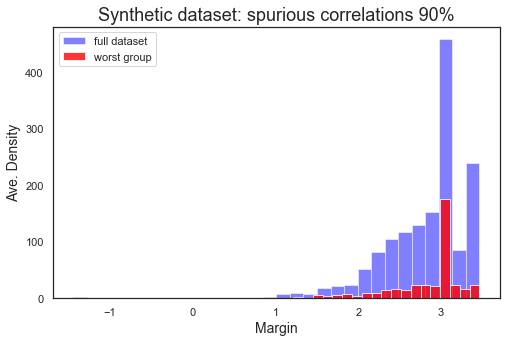

In [25]:
plot_margin(confidence = confidence_resnet_9,
            worst_group_idx = worst_group,
            spur_proportion = 90)

In [26]:
tau = np.linspace(0, 4, 100)
full_coverage_9 = [coverage(np.array(confidence_resnet_9), t) for t in tau]
full_accuracy_9 = [accuracy(np.array(confidence_resnet_9), t) for t in tau]
worst_coverage_9 = [coverage(np.array(confidence_resnet_9)[worst_group], t) for t in tau]
worst_accuracy_9 = [accuracy(np.array(confidence_resnet_9)[worst_group], t) for t in tau]

/Users/WMP/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [27]:
def plot_coverage(full_coverage, full_accuracy, worst_coverage, worst_accuracy, spur_proportion):
    '''This function plots the coverage on the x axis and the accuracy on the y axis
    for both the full dataset and the worst group in the dataset as defined in the paper.
    '''
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    ax.plot(full_coverage, full_accuracy, label = 'All data', color = 'blue')
    ax.plot(worst_coverage, worst_accuracy, label = 'Worst group', color = 'red')
    ax.set_xlabel('Coverage', fontsize = 14)
    ax.set_ylabel('Accuracy', fontsize = 14)
    ax.set_title("Synthetic dataset: spurious correlations {}%".format(spur_proportion), fontsize = 18)
    ax.legend()
    plt.show()

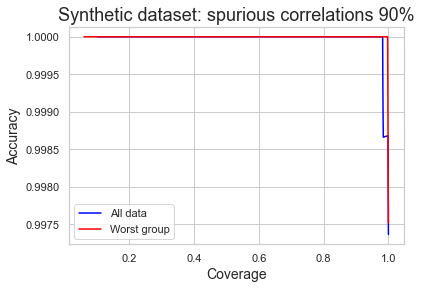

In [28]:
plot_coverage(full_coverage = full_coverage_9,
              full_accuracy = full_accuracy_9,
              worst_coverage = worst_coverage_9,
              worst_accuracy = worst_accuracy_9, 
              spur_proportion = 90)

In [ ]:
# TODO: add code to call plot functions for 70%, 50%, and 50% resnet models
# TODO: add code to call plot functions for 90%, 70%, 50%, and 50% keras simple models
# TODO: Add in discussion about keras vs resnet models
# TODO: double check that all code is well commented and readable for grading
# TODO: adjust the black boxes to be smaller or less dark as needed, depending on results


### Conclusions and Discussion
The authors claim that the results suggest that selective classification should be used with care and underscore the importance of training models to perform equally well across groups at full coverage. But it seems that the results may rely on the dataset being particular prone to spurious correlations and it is not clear that this phenomena is concerning across domains that consider using selective classification. 

Consider our toy datasets and the addition of black boxes that are essentially meaningless in the context of the classification task. Whether or not an image contains an artificially added black box is not related to the number written in the image. In addition to developing better selective classification techniques that reduce group disparities at full coverage, it also seems natural to consider addressing problematic characteristics of the dataset. If there are in fact spurious correlations present in a given dataset, how meaningful are the correlations? In our toy example, we could simply remove the black boxes in order to avoid the contrasting result. This makes us wonder if there is a more naïve approach where practitioners better examine dataset characteristics before applying methodologies like selective classification in order to avoid these types of issues altogether.

In the original paper, we see that in all these datasets, the "worst group" is underrepresented as in there are much fewer examples for the "worst group" category. Also, notice that the datasets considered in this paper do not seem immediately relevant in terms of the real world implications of disparities, we wonder how we might examine this using toy examples. Are there examples of real world datasets with meaningful use cases that demonstrate these same properties and if so, we wonder why the authors did not conduct their analysis on them.